## Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

## Dataset Exploration

In [2]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# dataset = ImageFolder('/content/drive/My Drive/SDD/images')
# dataset = ImageFolder('/content/drive/My Drive/420Dataset2/DBI')
dataset = ImageFolder('/content/drive/My Drive/420Dataset2')

In [4]:
len(dataset)

1901

In [5]:
len(dataset.classes)

2

In [6]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

## Creating training, validation and testing dataset

In [7]:
random_seed = 45
torch.manual_seed(random_seed);

In [8]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(1198, 133, 570)

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(1198, 133, 570)

SDD
<class 'PIL.Image.Image'>


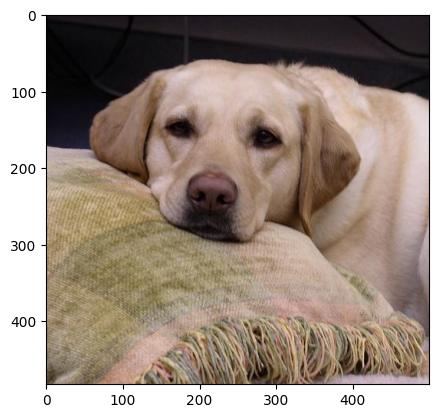

In [10]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

## Creating Custom Dataset

To create our custom Dataset, we need to extend Pytorch's `Dataset` class.
We need to implement 3 methods inside our Custom Dataset Class:

1. `__init__`
2. `__len__`
3. `__getitem__`

In [11]:
class DogBreedDataset(Dataset):

    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

In [12]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats, inplace=True)
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats, inplace=True)
])

In [13]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

Lets quickly take a look into our training dataset

1


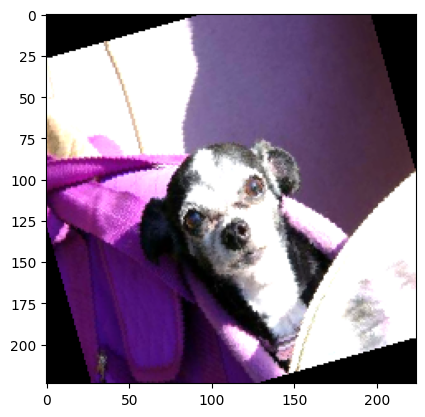

In [14]:
img, label = train_dataset[9]
print(label)
plt.imshow(img.permute(1,2,0))

Now we will create Training , validation data and test data loader

In [15]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

We can also take a peek into our dataset by creating grid of images using Pytorch's `make_grid()` method.

In [16]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

In [17]:
# show_batch(train_dl)

In [18]:
SDDdataset = ImageFolder('/content/drive/My Drive/420Dataset2/SDD')
sdd_dataset = DogBreedDataset(SDDdataset, test_transform)
sdd_dl = DataLoader(sdd_dataset, batch_size*2, num_workers=2, pin_memory=True)

## Network Architecture

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        _, preds = torch.max(out, dim=1)
        correct = torch.sum(preds == targets).item()
        total = len(preds)
        return loss, correct, total

    # training epoch end
    def training_epoch_end(self, outputs):
        batch_accs = [x for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return epoch_acc

    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}

    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    # test step
    def test_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'test_acc':acc.detach(), 'test_loss':loss.detach()}

    # test epoch end
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss':epoch_loss.item(), 'test_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(epoch,
        result["train_loss"], result["train_acc"], result["val_loss"], result["val_acc"], result["test_loss"], result["test_acc"]))


In [21]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
          #   • convolutional layer - 16 filters of size 3×3
          #   • batch normalization
          #   • convolutional layer - 16 filters of size 3×3
          #   • max pooling (2×2)
          #   • convolutional layer - 8 filters of size 3×3
          #   • batch normalization
          #   • convolutional layer - 8 filters of size 3×3
          #   • max pooling (2×2)
          #   • dropout (e.g. 0.5)
          #   • fully connected (32)
          #   • dropout (0.5)
          #   • softmax

            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(25088,32),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.Softmax(dim=1)
            )

    def forward(self, xb):
        return self.network(xb)

In [22]:
class DogBreedClassificationCNNwoDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(

            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(25088,32),
            # nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.Softmax(dim=1)
            )

    def forward(self, xb):
        return self.network(xb)

In [23]:
torch.manual_seed(1006765680)
model1 = DogBreedClassificationCNN()
model1_wo_dropout = DogBreedClassificationCNNwoDropout()

Let's define ResNet-34 Pre-trained model

### Let's now use some more pre-trained models

In [24]:
class DogBreedPretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [25]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [26]:
class DogBreedPretrainedResnet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [27]:
class DogBreedPretrainedSwinTransformer(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.swin_t(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.head.in_features
        self.network.head = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [28]:
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [29]:
class DogBreedPretrainedGoogleNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.googlenet(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [30]:
class DatasetDistinctionModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.googlenet(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [31]:
model1 = DatasetDistinctionModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 84.9MB/s]


## Moving Data to GPU

In [32]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [33]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [34]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
sdd_dl = DeviceDataLoader(sdd_dl, device)


# moving model to gpu
to_device(model1, device);
to_device(model1_wo_dropout, device);

cuda


## Training

In [35]:
# # check the model
# def try_batch(dl):
#     for imgs, labels in dl:
#         print("images shape : ", imgs.shape)
#         print("labels : ", labels)
#         outs = model1(imgs)                                  # Change model object here
#         print("outs.shape :", outs.shape)
#         print("outs : ", outs)
#         break

# try_batch(train_dl)

Now we'll train the model

In [36]:
from tqdm.notebook import tqdm

In [37]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        train_losses = []
        lrs = []
        correct = 0
        total = 0
        for batch in tqdm(train_loader):
            loss, correct_batch, total_batch = model.training_step(batch)
            correct += correct_batch
            total += total_batch

            train_losses.append(loss)

            # calculates gradients
            loss.backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate_val(model, val_loader)
        result.update(evaluate_test(model, test_loader))
        result['train_acc'] = correct / total
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history



@torch.no_grad()
def evaluate_val(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def evaluate_test(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

@torch.no_grad()
def evaluate_train(model, train_loader):
    model.eval()
    outputs = [model.training_step(batch) for batch in train_loader]
    # print(outputs)
    return model.training_epoch_end(outputs)

In [38]:
# evaluate_val(model1, val_dl)                 # change model object here

In [39]:
# evaluate_test(model1, test_dl)

In [40]:
# evaluate_train(model1, train_dl)
# # print(test_dl)

In [41]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [42]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.6835, train_acc: 0.5952, val_loss: 0.4474, val_acc: 0.8398, test_loss: 0.5684, test_acc: 0.7070


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.5315, train_acc: 0.7145, val_loss: 0.2648, val_acc: 0.9258, test_loss: 0.4285, test_acc: 0.7698


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.3556, train_acc: 0.8289, val_loss: 0.2077, val_acc: 0.9492, test_loss: 0.3608, test_acc: 0.8311


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.2743, train_acc: 0.8856, val_loss: 0.2110, val_acc: 0.9570, test_loss: 0.3531, test_acc: 0.8283


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.2365, train_acc: 0.9032, val_loss: 0.2046, val_acc: 0.9336, test_loss: 0.3789, test_acc: 0.8230


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.1974, train_acc: 0.9182, val_loss: 0.1798, val_acc: 0.9453, test_loss: 0.2960, test_acc: 0.8674


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.1878, train_acc: 0.9274, val_loss: 0.1802, val_acc: 0.9531, test_loss: 0.2982, test_acc: 0.8537


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.1532, train_acc: 0.9449, val_loss: 0.1962, val_acc: 0.9375, test_loss: 0.3155, test_acc: 0.8586


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.1372, train_acc: 0.9457, val_loss: 0.1904, val_acc: 0.9453, test_loss: 0.3003, test_acc: 0.8643


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.1424, train_acc: 0.9482, val_loss: 0.1865, val_acc: 0.9531, test_loss: 0.2951, test_acc: 0.8762


In [43]:
# history2 = fit_one_cycle(num_epochs, max_lr, model1_wo_dropout, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

## Plotting history

In [2]:
#testing SDD

result = evaluate_test(model1, sdd_dl)

In [ ]:
result['test_acc']

In [ ]:
history[0].keys()

In [45]:
history_f = history
# history_f = history2

val_loss = []
train_loss = []
val_acc = []
test_acc = []
train_acc = []
time = list(range(len(history_f)))
for h in history_f:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    test_acc.append(h['test_acc'])
    train_acc.append(h['train_acc'])

### Loss v/s Epochs plot

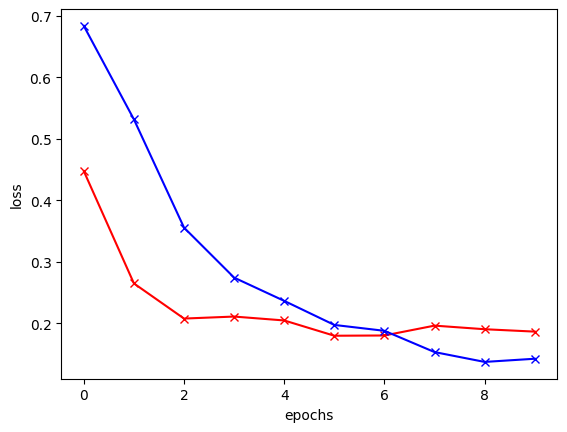

In [46]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Accuracy v/s Epochs plot

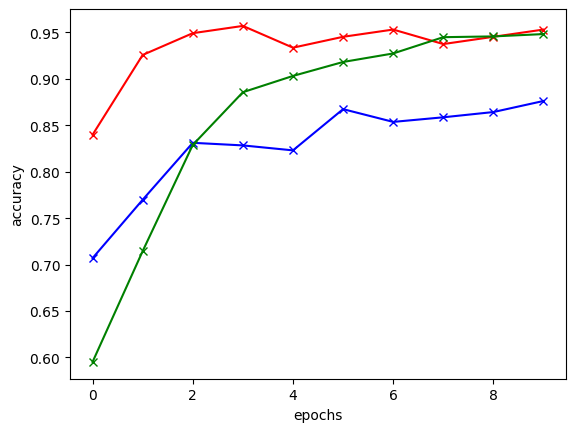

In [47]:
plt.plot(time, val_acc, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='green', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

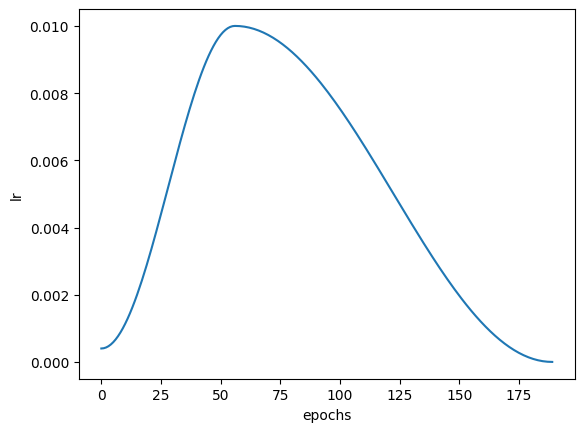

In [48]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

## Prediction

In [ ]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model1(xb)                   # change model object here
    predictions = preds[0]

    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

In [ ]:
predict_single(*test_dataset[6])

NameError: ignored

Actual : Scottish deerhound  | Predicted : Scottish deerhound


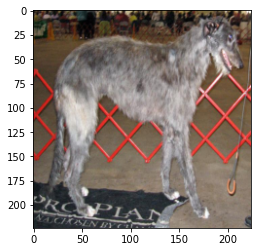

In [ ]:
predict_single(*test_dataset[1])

Actual : Italian greyhound  | Predicted : Italian greyhound


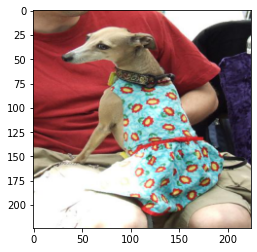

In [ ]:
predict_single(*test_dataset[93])

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
result = evaluate(model1, test_dl)
result

{'val_loss': 0.45727336406707764, 'val_acc': 0.8556122183799744}

## Save model

In [ ]:
weights_fname = 'dog-breed-classifier-wideresnet_with_data_aug.pth'
torch.save(model4.state_dict(), weights_fname)

## Commit to Jovian

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='wideresnet_with_data_aug',
                       epochs=len(history),
                       max_lr_01=0.01,
                       max_lr_02=0.001,
                       max_lr_03=0.0001,
                       scheduler='one-cycle',
                       batch_size = batch_size,
                       weight_decay=weight_decay,
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(
    train_loss=history[-1]['train_loss'],
    val_loss=history[-1]['val_loss'],
    val_score=history[-1]['val_acc'],
    test_score=result['val_acc'],
    test_loss=result['val_loss']
)

[jovian] Metrics logged.


In [ ]:
project_name='dog-breed-classifier-final'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/ankitvashisht12/dog-breed-classifier-final


<IPython.core.display.Javascript object>